<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>


---

# RNNs and LSTMs (Solutions):




#### A few imports and functions before we get started

In [1]:
!pip install pycm livelossplot
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import random
import time
import math

import glob
import string
import unicodedata
import re
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from livelossplot import PlotLosses

import pandas as pd


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

No GPU available! Running on CPU


In [6]:
def readFile_csv(filename, header):
    """
    Read a csv file and return list with line entries
    """
    dataframe = pd.read_csv(filename)
    data = dataframe[header].str.cat(sep=' ')
    data = data.split(' ')
    return data

filename, header = 'data_gen/reddit-cleanjokes.csv', 'Joke'
data = readFile_csv(filename, header)


In [4]:
class WordsTensorDataset(TensorDataset):
    def __init__(self, data_list, sequence_length=4):
        """
        Args:
            data_list (dictionary): A list of all the words in the file
            sequence_length: the number of words in each input sample, and output sample
        """
        self.sequence_length = sequence_length
        self.data_list = data_list
        self.unique_words = self.get_unique_words()

        self.word_to_idx = {word: idx for idx, word in enumerate(self.unique_words)}  # create a dictionary of mappings of words to indices
        self.idx_to_word = {idx: word for idx, word in enumerate(self.unique_words)}  # create a dictionary of mappings of indices to words

        self.words_idxs = [self.word_to_idx[word] for word in data]                   # return a list of the dat with the words represented with their indices

    def get_unique_words(self):
        word_counts = Counter(self.data_list)
        return sorted(word_counts, key=word_counts.get, reverse=True)                 # return a list of the unique words sorted in ascending order

    def __len__(self):
        return len(self.words_idxs) - self.sequence_length

    def __getitem__(self, idx):

        sample_input = torch.tensor(self.words_idxs[idx:idx+self.sequence_length])       # get a sample input sequence
        sample_output = torch.tensor(self.words_idxs[idx+1:idx+self.sequence_length+1])  # get a sample output sequence

        return sample_input, sample_output

In [7]:
words_dataset = WordsTensorDataset(data, sequence_length=4)  # create a dataset
words_dataloader = DataLoader(words_dataset, batch_size=5, shuffle=False)  # use the dataset with a data loader

next(iter(words_dataloader))

[tensor([[   2,    8,    0,  248],
         [   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905]]),
 tensor([[   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905],
         [   4,    0, 1905, 1906]])]

# RNNS

In [11]:
class RNNCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True, activation="tanh"):
        super(RNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # select appropriate activation function
        if activation == 'tanh':
            self.act = nn.Tanh()
        elif activation == 'ReLU':
            self.act = nn.ReLU()

        self.i2h = nn.Linear(input_size, hidden_size, bias=bias)    # create linear layer from input to hidden state
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)   # create linear layer from previous to current hidden state

        self.reset_parameters()                                     # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h):
        input = self.i2h(input)                                     # map from input to hidden state space
        h = self.h2h(h)                                             # map from previous to current hidden state space
        h = self.act(input + h)                                     # calculate new hidden state by applying activation
        
        return h

In [12]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False, activation='tanh'):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bias = bias

        self.rnn_cell_list = nn.ModuleList()                         # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers
        for l in range(self.num_layers):
            self.rnn_cell_list.append(RNNCell(self.input_size if l == 0 else self.hidden_size,
                                                self.hidden_size,
                                                self.bias,
                                                activation))

        self.h2o = nn.Linear(self.hidden_size, self.output_size)     # create a final linear layer from hidden state to network output

    def init_hidden(self,  batch_size=1):
        # initialise the hidden state
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device)

    def forward(self, input, h0):
        # Input of shape (batch_size, seqence length, input_size)
        # Output of shape (batch_size, output_size)

        outs = []
        hidden = []
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        batch_size = input.size(0)
        step_size = input.size(1)

        # iterate over all elements in the sequence
        for t in range(step_size):
            # iterate over each layer
            for layer in range(self.num_layers):
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer])

                # store the hidden state of each layer
                hidden[layer] = hidden_l

            # the hidden state of the last layer needs to be recorded
            # to be used in the output
            outs.append(hidden_l)

        # calculate output for each element in the sequence
        out = torch.stack([self.h2o(out) for out in outs], dim=1)

        return out

In [13]:
class RNN_GEN(nn.Module):

    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(RNN_GEN, self).__init__()

        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        
        self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)                   # add a nn.Embedding
        self.rnn = RNN(self.input_size, self.hidden_size, self.num_layers, self.num_unique_words,  # add our RNN
                       bias=False, activation='tanh')

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.rnn.init_hidden(batch_size)      # initialise hidden state

        embedded = self.embedding(x)                   # store the word embeddings
        output = self.rnn(embedded, hidden)            # apply the RNN

        return output

# rnn class descriptions:

In [19]:
# functions:

RNNCell(
    input_size=4, 
    hidden_size=16, 
    bias=True, 
    activation="tanh"
)
# inputs: Embedded words, and the previous state
# outputs: the nn'ed output (not formatted for the final layer.) 
# graphical desc: The folded rnn diagram. One single RNN column thing
# Allows us to use single loop diagram, but extend it to have more 
# hidden layers idefinitelly.

RNNCell(
  (act): Tanh()
  (i2h): Linear(in_features=4, out_features=16, bias=True)
  (h2h): Linear(in_features=16, out_features=16, bias=True)
)

In [35]:
RNN(
    input_size=4, 
    hidden_size=16, 
    num_layers=2, 
    output_size=1, 
    bias=False, 
    activation='tanh'
)
# inputs:
# All of the inputs for an indivudual cell 
# + a number of hidden layers (higher number means the single loop diagram is taller with more h nodes)
# + an output size. 

# outputs: 
# The output layer of the RNN. Still needs to be softmaxed
# Given an input sequence [word1, word2, word3], your RNN model 
# returns info to predict [word2_predicted, word3_predicted, word4_predicted] 

# graphical desc: The RNNCell allows us to dynamically add more hidden layers,
# this function forcwes us to choose the output size and will add it on the the 
# end of the RNNCell we define at the start.

RNN(
  (rnn_cell_list): ModuleList(
    (0): RNNCell(
      (act): Tanh()
      (i2h): Linear(in_features=4, out_features=16, bias=False)
      (h2h): Linear(in_features=16, out_features=16, bias=False)
    )
    (1): RNNCell(
      (act): Tanh()
      (i2h): Linear(in_features=16, out_features=16, bias=False)
      (h2h): Linear(in_features=16, out_features=16, bias=False)
    )
  )
  (h2o): Linear(in_features=16, out_features=1, bias=True)
)

In [36]:
RNN_GEN(
    input_size=6, 
    embedding_dim=6, 
    hidden_size=5, 
    num_layers=2, 
    num_unique_words=100)
# graphical desc: 
# This function is similar to RNN, but its a higher level function that does word 
# embedding for us. This means we need to do less preprocessing.
# inputs: non-embedded data.
# outputs: Same as RNN()

RNN_GEN(
  (embedding): Embedding(100, 6)
  (rnn): RNN(
    (rnn_cell_list): ModuleList(
      (0): RNNCell(
        (act): Tanh()
        (i2h): Linear(in_features=6, out_features=5, bias=False)
        (h2h): Linear(in_features=5, out_features=5, bias=False)
      )
      (1): RNNCell(
        (act): Tanh()
        (i2h): Linear(in_features=5, out_features=5, bias=False)
        (h2h): Linear(in_features=5, out_features=5, bias=False)
      )
    )
    (h2o): Linear(in_features=5, out_features=100, bias=True)
  )
)

In [70]:
model1 = RNN_GEN(
    input_size=5, 
    embedding_dim=5, 
    hidden_size=5, 
    num_layers=2, 
    num_unique_words=5)
model1

RNN_GEN(
  (embedding): Embedding(5, 5)
  (rnn): RNN(
    (rnn_cell_list): ModuleList(
      (0-1): 2 x RNNCell(
        (act): Tanh()
        (i2h): Linear(in_features=5, out_features=5, bias=False)
        (h2h): Linear(in_features=5, out_features=5, bias=False)
      )
    )
    (h2o): Linear(in_features=5, out_features=5, bias=True)
  )
)

In [80]:
X

tensor([[   2,    8,    0,  248],
        [   8,    0,  248,   20],
        [   0,  248,   20,    4],
        [ 248,   20,    4,    0],
        [  20,    4,    0, 1905]])

In [97]:
model1 = RNN_GEN(
    
    # embedding information
    # These next 2 params must be equal
    
    # Our words are represented by a point in an n-dimensional space.
    # embedding_dim is n  
    embedding_dim=3,
    
    # slightly redundant
    # must equal embedding_dim. 
    # we embed our input, and get a point/vector that has embedding_dim dimensions.  
    input_size=3, 

    # width, can be whatever
    hidden_size=5, 
    
    # lenth/height of the folding diagram. Can be whatever.
    num_layers=2, 
    
    # vocab size. At least as high as the highest baatch idx
    num_unique_words=1906  
)


In [112]:
X, y = next(iter(words_dataloader))
print(f"The shape of X is {X.shape}\n")

print("And now for the shape of our model output:::")
print("torch.Size([batch_size, sequence_length, num_words])")
print(model1(X).shape)

The shape of X is torch.Size([5, 4])

And now for the shape of our model output:::
torch.Size([batch_size, sequence_length, num_words])
torch.Size([5, 4, 1906])


In [114]:
# contains the predicted next word (Not the actual prediction, 
# just the logits) at each of the 4 timesteps for the first sequence in our batch X
model1(X)[0]

tensor([[-0.2457, -0.4530, -0.1851,  ...,  0.0105, -0.1072, -0.1453],
        [-0.1796, -0.3450, -0.1877,  ..., -0.0048, -0.0768, -0.2157],
        [-0.1885, -0.3829, -0.2446,  ..., -0.0217, -0.0585, -0.1821],
        [-0.2813, -0.2280,  0.1243,  ..., -0.0473, -0.2774, -0.4262]],
       grad_fn=<SelectBackward0>)

# LSTMS

In [126]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # we will streamline the implementation of the LSTM by combining the
        # weights for all 4 operations (input gate, forget gate, output gate, candidate update)
        self.i2h = nn.Linear(input_size, hidden_size * 4, bias=bias)       # create a linear layer to map from input to hidden space
        self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)      # create a linear layer to map from previous to current hidden space

        self.reset_parameters()                                            # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h, c):
        gates = self.i2h(input) + self.h2h(h)                              # apply the weights to both input and previous state

        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, 1)  # separate the output into each of the LSTM operations

        # apply the corresponding activations
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        c_t = torch.tanh(candidate_update)
        o_t = torch.sigmoid(output_gate)

        c = f_t * c + i_t * c_t                                             # calculate the next cell state

        h = o_t * torch.tanh(c)                                             # calculate the next hidden state

        return h, c


In [127]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()                         # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers
        for l in range(self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.input_size if l == 0 else self.hidden_size,
                                               self.hidden_size,
                                               self.bias))

        self.h2o = nn.Linear(self.hidden_size, self.output_size)     # create a final linear layer from hidden state to network output

    def init_hidden(self,  batch_size=1):
        # initialise the hidden state and cell state
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device))

    def forward(self, input, h0, c0):
        # Input of shape (batch_size, seqence length , input_size)
        # Output of shape (batch_size, output_size)

        outs = []

        hidden = []
        cell = []
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])
            cell.append(c0[layer, :, :])

        # iterate over all elements in the sequence
        for t in range(input.size(1)):
            # iterate over each layer
            for layer in range(self.num_layers):
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number
                if layer == 0:
                    hidden_l, cell_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer], cell[layer])
                else:
                    hidden_l, cell_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer], cell[layer])

                # store the hidden and cell state of each layer
                hidden[layer] = hidden_l
                cell[layer] = cell_l

            # the hidden state of the last layer needs to be recorded
            # to be used in the output
            outs.append(hidden_l)

        # calculate output for each element in the sequence
        out = torch.stack([self.h2o(out) for out in outs], dim=1)

        return out

In [134]:
class LSTM_GEN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words, batch_size):
        super(LSTM_GEN, self).__init__()

        # define your layers and activations
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)                    # add a nn.Embedding
        self.lstm = LSTM(self.input_size, self.hidden_size, self.num_layers, self.num_unique_words) # add out LSTM

    def forward(self, x):
        batch_size = x.size(0)

        state_h, state_c = self.lstm.init_hidden(batch_size)    # initialise hidden state

        embedded = self.embedding(x)                            # store the word embeddings
        output = self.lstm(embedded, state_h, state_c)          # apply the LSTM

        return output

In [120]:
# ==================================================================================


## LSTM class descriptions:

/bin/bash: line 1: [file:///home/javonne/Pictures/Screenshots/Screenshot%20from%202023-12-13%2016-05-24.png]: No such file or directory


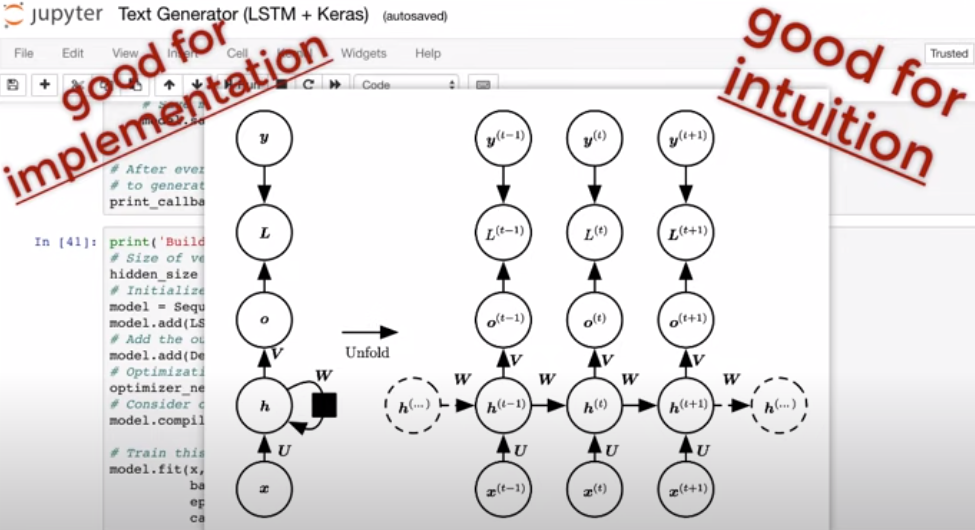

In [130]:
LSTMCell(
    input_size=5, 
    hidden_size=5, 
    bias=True
)

LSTMCell(
  (i2h): Linear(in_features=5, out_features=20, bias=True)
  (h2h): Linear(in_features=5, out_features=20, bias=True)
)

In [131]:
LSTM(
    input_size=5, 
    hidden_size=5, 
    num_layers=2, 
    output_size=6, 
    bias=False
)

# inputs:
# outputs:
# graphical description:

LSTM(
  (rnn_cell_list): ModuleList(
    (0-1): 2 x LSTMCell(
      (i2h): Linear(in_features=5, out_features=20, bias=False)
      (h2h): Linear(in_features=5, out_features=20, bias=False)
    )
  )
  (h2o): Linear(in_features=5, out_features=6, bias=True)
)

In [137]:
# ==================================================================================
LSTM_GEN(
    input_size=5, 
    embedding_dim=5, 
    hidden_size=5, 
    num_layers=5, 
    num_unique_words=500, 
    batch_size=41
)

# inputs:
# outputs:
# graphical description:

LSTM_GEN(
  (embedding): Embedding(500, 5)
  (lstm): LSTM(
    (rnn_cell_list): ModuleList(
      (0-4): 5 x LSTMCell(
        (i2h): Linear(in_features=5, out_features=20, bias=False)
        (h2h): Linear(in_features=5, out_features=20, bias=False)
      )
    )
    (h2o): Linear(in_features=5, out_features=500, bias=True)
  )
)

In [116]:
# ==================================================================================


# Recent Advances

The long-term memory in LSTM is [a specific instance](https://arxiv.org/pdf/1601.06733.pdf) of a more generic concept called _Attention_. The concept of Attention was introduced to solve one problem - when doing _Neural Machine Translation_ , the next word in the output sentence (in the output language) is not necessary related to the last (or second-to-last) word in the input sentence (in the input language). Since simple RNNs can only capture adjacency relationships, various styles of attention were tried to teach the model to look at a specific part of the input sentence in order to predict the next output word. [Many of these attention approaches](https://arxiv.org/abs/1409.0473) were successful and today far outperform LSTMs on the above tasks.

![](https://github.com/acse-2020/ACSE-8/blob/main/implementation/practical_5/morning_lecture/images/self-attention.png?raw=1)

One extremely successful kind of attention is _self attention_. Here, instead of mapping relationships between an output sequence and an input sequence, we map relationships between the different words of the same sentence. Going down this path, it was realised that the self-attention mechanism is more than just an add-on to RNNs and it might be possible to build entire networks out of self-attention alone. In ["Attention is all you need" (Vasuvani 2017)](https://arxiv.org/pdf/1706.03762.pdf) a neural network architecture called _Transformer_ was introduced that was composed entirely of self attention layers, and had some other innovations regarding memory.

![](https://github.com/acse-2020/ACSE-8/blob/main/implementation/practical_5/morning_lecture/images/transformer.png?raw=1)

In Feb 2019, a company called OpenAI introduced a variation of the transformer called GPT2 and [refused to release](https://slate.com/technology/2019/02/openai-gpt2-text-generating-algorithm-ai-dangerous.html) it _claiming it might destroy human society_ . This was a text generation model that could generate entire (_fake_) news articles from a one/few word prompt - think of it as autocomplete on steroids. They did eventually release it and is now available to try online: https://talktotransformer.com